# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

In [68]:
## Imports

In [69]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [70]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [71]:
# Specify data URI
URI = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.dropna()
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()
#print(f"{train_stats}")

#print(f"train = {train}")
#print(f"test = {test}")
# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
#print(f"{train_stats}")
train_stats.pop('Y2')
#print(f"{train_stats}")
train_stats = train_stats.transpose()
#print(f"{train_stats}")
train_Y = format_output(train)
test_Y = format_output(test)

#print(f"train_Y = {train_Y}")
#print(f"test_Y = {test_Y}")


# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

#print(f"norm_train_X = {norm_train_X}")
#print(f"norm_test_X = {norm_test_X}")

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [72]:
# Define model layers.
#print(f"train.columns = {train.columns}")
#print(f"len(train.columns) = {len(train.columns)}")
input_layer = Input(shape=(len(train.columns), ))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 8)]          0           []                               
                                                                                                  
 dense_36 (Dense)               (None, 128)          1152        ['input_13[0][0]']               
                                                                                                  
 dense_37 (Dense)               (None, 128)          16512       ['dense_36[0][0]']               
                                                                                                  
 dense_38 (Dense)               (None, 64)           8256        ['dense_37[0][0]']               
                                                                                           

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

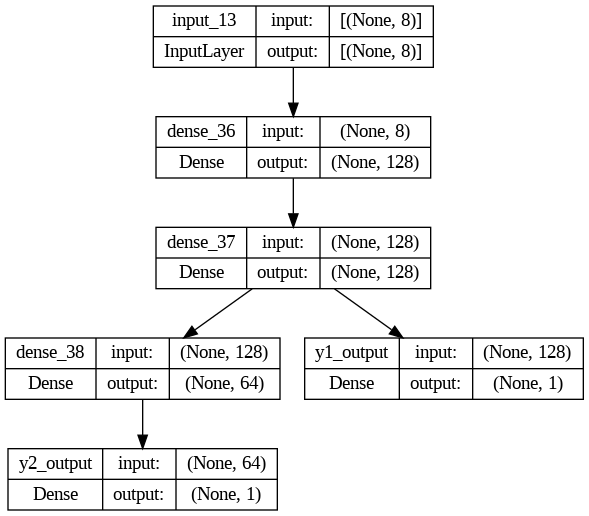

In [73]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

from tensorflow.keras.layers import Layer
model._layers = [layer for layer in model.layers if isinstance(layer, Layer)]
plot_model(model)
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

## Train the Model

In [74]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 1s 5ms/step - loss: 248.4460 - y1_output_loss: 122.0400 - y2_output_loss: 126.4060 - y1_output_root_mean_squared_error: 11.0472 - y2_output_root_mean_squared_error: 11.2430 - val_loss: 116.4875 - val_y1_output_loss: 25.5533 - val_y2_output_loss: 90.9342 - val_y1_output_root_mean_squared_error: 5.0550 - val_y2_output_root_mean_squared_error: 9.5359
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 32.2522 - y1_output_loss: 12.9355 - y2_output_loss: 19.3168 - y1_output_root_mean_squared_error: 3.5966 - y2_output_root_mean_squared_error: 4.3951 - val_loss: 83.3554 - val_y1_output_loss: 16.7583 - val_y2_output_loss: 66.5971 - val_y1_output_root_mean_squared_error: 4.0937 - val_y2_output_root_mean_squared_error: 8.1607
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 29.6672 - y1_output_loss: 11.0818 - y2_output_loss: 18.5854 - y1_output_root_mean_squared_error: 3.3289 - y2_output_root_mean_s

## Evaluate the Model and Plot Metrics

In [75]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 2ms/step - loss: 0.5183 - y1_output_loss: 0.1513 - y2_output_loss: 0.3670 - y1_output_root_mean_squared_error: 0.3890 - y2_output_root_mean_squared_error: 0.6058
Loss = 0.5183179974555969, Y1_loss = 0.15134026110172272, Y1_mse = 0.3890247642993927, Y2_loss = 0.3669777512550354, Y2_mse = 0.6057868599891663


5/5 [==============================] - 0s 2ms/step


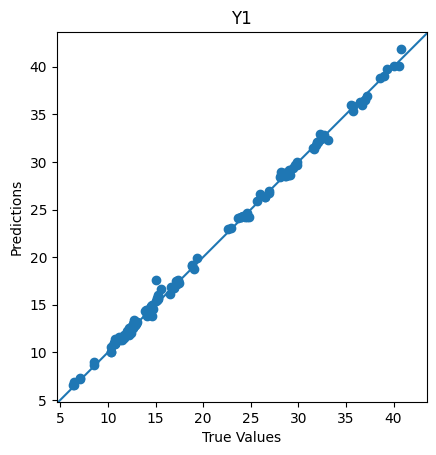

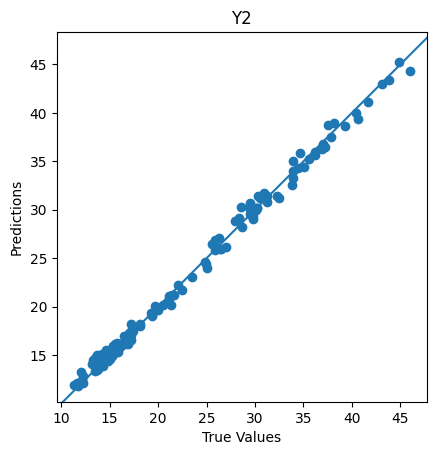

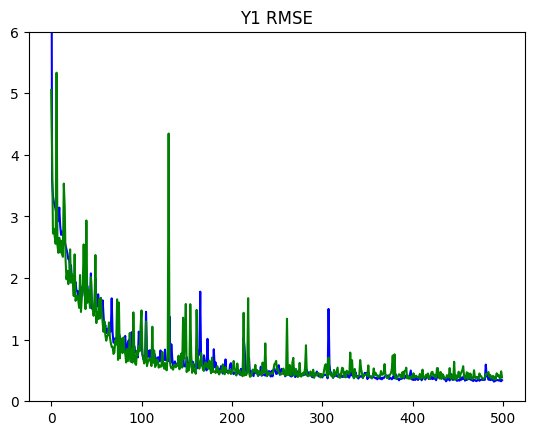

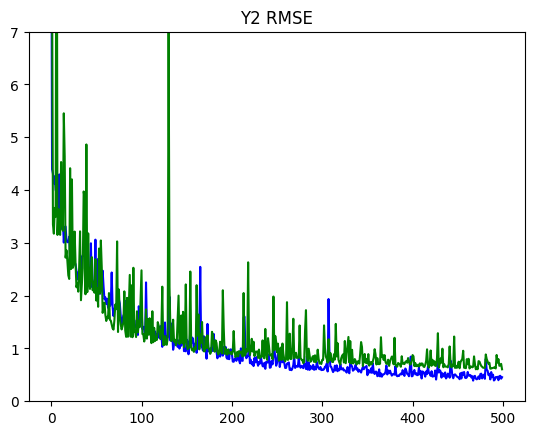

In [76]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)